In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from numpy import arcsin, sqrt

os.chdir("/Users/lgorman/research/phd/farm-size-modelling")

In [221]:
rhomis_data = pd.read_csv("./data/prepped-data/rhomis-ee-gaez.csv")
# rhomis_data["geo_id"] = rhomis_data["ADM0_CODE"] +"_"+ rhomis_data["ADM1_CODE"] +"_"+ rhomis_data["ADM2_CODE"]

land_categories = pd.read_csv("./data/prepped-data/land_cover_classes.csv")


In [222]:
# Convert land cat pixel count to proporiton

land_cat_columns = ["land_cat_"+str(n) for n in range(1, land_categories.shape[0]+1)]

for land_cat_column in land_cat_columns:
    rhomis_data[land_cat_column] = rhomis_data[land_cat_column].fillna(0)
    rhomis_data[land_cat_column]=rhomis_data[land_cat_column]/rhomis_data["pixelCount"]


In [223]:
# Creating a dictionary to switch land category columns
new_col = ["land_cat_"+str(n) for n in range(1, land_categories.shape[0]+1)]
land_categories["colname"]=new_col
land_cat_switch_dict = {}
for i in range(0,land_categories.shape[0]):
    land_cat_switch_dict[land_categories.loc[i, "colname"]]=land_categories.loc[i, "Tag"]




# Dictionary to rename earth engine columns
column_renames_dict = {'accessibility_mean': 'healthcare_traveltime',
        'b1_mean_mean': 'nightlights',
        'population_density_mean_mean': 'population_density',
        'elevation_mean':'elevation',
        'NDVI_mean_mean': 'ndvi',
        'constant_mean': 'topographic_diversity',
        'accessibility_mean': 'healthcare_traveltime',
        'b1_mean_mean': 'nightlights',
        'population_density_mean_mean': 'population_density',
        'elevation_mean': 'elevation',
        'NDVI_mean_mean': 'ndvi',
        'constant_mean': 'topographic_diversity'}
rhomis_data.rename(columns=column_renames_dict,
          inplace=True)
rhomis_data.rename(columns=land_cat_switch_dict,
          inplace=True)


In [224]:
# Removing rows with NA
valid_rows = rhomis_data["land_cultivated_ha"].notna()
rhomis_data = rhomis_data[valid_rows]

In [225]:


aez_cols = list(rhomis_data.columns[rhomis_data.columns.str.contains('AEZ_Classes_', regex=False)])
aez_cols = [ col for col in aez_cols if col !="AEZ_Classes_33"]





In [226]:
# Arcsin transform
rhomis_data[aez_cols]=rhomis_data[aez_cols].apply(sqrt).apply(arcsin)


In [227]:
x_cols = ["healthcare_traveltime",
       "nightlights",
       "population_density",
       "elevation",
       "ndvi",
       "topographic_diversity",
       "adjusted_length_growing_period"]
x_cols.extend(aez_cols)
x_cols.extend(land_categories["Tag"])
x = rhomis_data[x_cols]

y = rhomis_data["land_cultivated_ha"]

In [228]:
from sklearn.utils.fixes import sp_version, parse_version

# This is line is
#  to avoid incompatibility if older SciPy version.
# You should use `solver="highs"` with recent version of SciPy.
solver = "highs" if sp_version >= parse_version("1.6.0") else "interior-point"

In [229]:
from sklearn.linear_model import QuantileRegressor
# from sklearn.ensemble import BaggingRegressor

# quantiles = [0.05,0.1, 0.25,0.5, 0.75,0.95]

# predictions = {}
# for quantile in quantiles:
#     qr = QuantileRegressor(quantile=quantile, alpha=1, solver=solver)
#     y_pred = qr.fit(x, y).predict(x)
#     predictions[quantile] = y_pred


# model = BaggingRegressor(estimator=QuantileRegressor(quantile=0.1, alpha=0, solver=solver)).fit(x, y)
model =  QuantileRegressor(quantile=0.1, alpha=0.05, solver=solver).fit(x, y)


In [175]:
results = pd.DataFrame({
    'vars':model.feature_names_in_,
    'coefficients': model.coef_
}).transpose()

results

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
vars,healthcare_traveltime,nightlights,population_density,elevation,ndvi,topographic_diversity,adjusted_length_growing_period,AEZ_Classes_33_cold_no_permafrost_moist,AEZ_Classes_33_desert_or_arid_climate,AEZ_Classes_33_dominantly_built_up_land,...,woody_savana,savana,grass_land,wetland,cropland,urban,crop_natural_mosaic,snow_ice,barren,water_bodies
coefficients,0.001306,0.0,-0.00011,-0.000212,-0.000016,0.0,-0.002562,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [184]:
run_name = 'run_'+str(1)
results = pd.DataFrame.from_dict({
   run_name : model.coef_
},columns= model.feature_names_in_,orient='index')
results

,healthcare_traveltime,nightlights,population_density,elevation,ndvi,topographic_diversity,adjusted_length_growing_period,AEZ_Classes_33_cold_no_permafrost_moist,AEZ_Classes_33_desert_or_arid_climate,AEZ_Classes_33_dominantly_built_up_land,...,woody_savana,savana,grass_land,wetland,cropland,urban,crop_natural_mosaic,snow_ice,barren,water_bodies
run1,0.001306,0.0,-0.00011,-0.000212,-0.000016,0.0,-0.002562,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [259]:
from sklearn.utils import resample

quanitle=0.1

n_iterations = 1000
n_size = int(y.shape[0] * 0.50)

whole_sample_list = [i for i in range(0,y.shape[0])]
i = 1

results_frames = []
for i in range(0,n_iterations):

    sub_sample_list = resample(whole_sample_list, n_samples=n_size)

    x_subsample = x.iloc[sub_sample_list,:]
    y_subsample = y.iloc[sub_sample_list]
    
    model =  QuantileRegressor(quantile=quanitle, alpha=0.05, solver=solver).fit(x_subsample, y_subsample)

    run_name = 'run_'+str(i)
    results = pd.DataFrame.from_dict({
    run_name : model.coef_
    },columns= model.feature_names_in_,orient='index')

    results_frames.append(results)

result = pd.concat(results_frames)
result
  


,healthcare_traveltime,nightlights,population_density,elevation,ndvi,topographic_diversity,adjusted_length_growing_period,AEZ_Classes_33_cold_no_permafrost_moist,AEZ_Classes_33_desert_or_arid_climate,AEZ_Classes_33_dominantly_built_up_land,...,woody_savana,savana,grass_land,wetland,cropland,urban,crop_natural_mosaic,snow_ice,barren,water_bodies
run_0,0.002270,0.0,-0.000078,-0.000229,-4.376210e-07,0.0,-0.002423,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
run_1,0.000979,0.0,-0.000107,-0.000162,-3.251416e-05,0.0,-0.002248,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
run_2,0.001115,0.0,-0.000111,-0.000213,-2.098926e-05,0.0,-0.002515,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
run_3,0.002192,0.0,-0.000093,-0.000184,-2.069301e-05,0.0,-0.002431,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
run_4,0.001187,0.0,-0.000114,-0.000216,-9.471980e-06,0.0,-0.002805,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
run_995,0.000468,0.0,-0.000101,-0.000210,-4.676523e-06,0.0,-0.003512,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
run_996,0.001471,0.0,-0.000135,-0.000205,-1.329945e-05,0.0,-0.002262,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
run_997,0.001218,0.0,-0.000110,-0.000185,-2.511217e-05,0.0,-0.002646,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
run_998,0.001614,0.0,-0.000102,-0.000221,-1.668696e-05,0.0,-0.002652,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


array([[<AxesSubplot: title={'center': 'healthcare_traveltime'}>,
        <AxesSubplot: title={'center': 'population_density'}>],
       [<AxesSubplot: title={'center': 'elevation'}>,
        <AxesSubplot: title={'center': 'ndvi'}>],
       [<AxesSubplot: title={'center': 'adjusted_length_growing_period'}>,
        <AxesSubplot: >]], dtype=object)

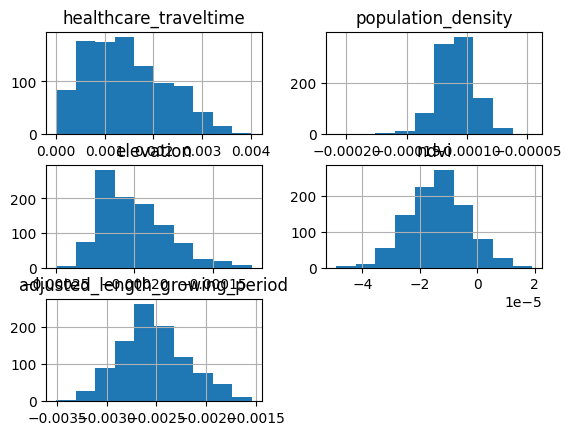

In [266]:
# identify all columns with zero coefficient
non_zero_result = result.columns[(result == 0).all()==False]
result[non_zero_result].hist()

13453     8.00
3308     15.00
225       4.00
2205      2.40
18531     6.40
         ...  
1710      0.80
6424      0.75
5487      0.25
17907     3.00
982       5.00
Name: land_cultivated_ha, Length: 9918, dtype: float64

In [252]:
y.iloc[6746]

4.5

In [268]:

# What would the predictions look like



prediction = model.predict(rhomis_data[x_cols])



(array([1103., 1511., 2790., 2826., 2576., 2864., 5287.,  775.,   59.,
          45.]),
 array([-0.02024343,  0.10678091,  0.23380525,  0.3608296 ,  0.48785394,
         0.61487828,  0.74190263,  0.86892697,  0.99595131,  1.12297566,
         1.25      ]),
 <BarContainer object of 10 artists>)

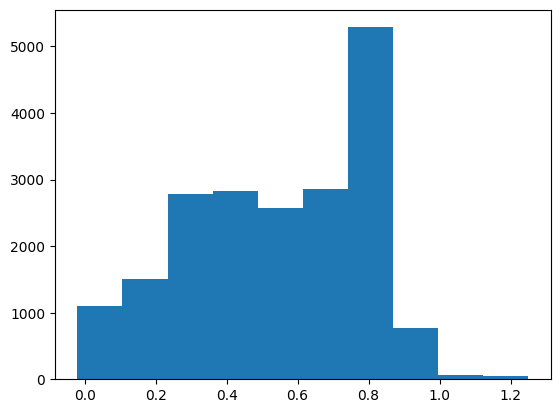

In [270]:
import matplotlib.pyplot as plt


plt.hist(prediction)